In [1]:
import pandas as pd
import numpy as np
import shutil
import subprocess
import time
import pandas as pd
import sqlite3
import numpy as np
calibration_start_time = time.time()


# MinDist = 1 #1~3
# MaxAcc = 3 #2.5~3
# NormalDec = 4 #4~5.3
# MaxDec = 6 #5~9.3
# MinHeadway = 0 #0.25~1.25
# SensitivityFactor = 1 #0~1
initial_solution = np.array([1,3,4,6,0,1])

def newParameter(initial_solution):
    Parameter = np.genfromtxt('DrivingBehaviorParameter.csv', delimiter=',')
    Parameter = initial_solution
    np.savetxt('DrivingBehaviorParameter.csv', Parameter, delimiter=',', fmt='%s')

   
    # cmd1 = '"C:\\Program Files\\Aimsun\\Aimsun Next 23\\Aimsun Next.exe" --project "D:\\RealTwin\\Real-Twin Workflow Paper\\aimsun simulation_0506actuatedsignal\\chatt.ang" --command execute --target 1269'
    cmd1 = '"C:\\Program Files\\Aimsun\\Aimsun Next 23\\aconsole.exe" -script "C:\\Users\\xugua\\Downloads\\RealTwin Calibration\\aimsun simulation_0506actuatedsignal\\DrivingBehavior.py" "C:\\Users\\xugua\\Downloads\\RealTwin Calibration\\aimsun simulation_0506actuatedsignal\\chatt.ang"'
    process = subprocess.Popen(cmd1, shell=True)
    # process = subprocess.Popen(cmd1, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    process.wait()

def runAimsun():
    cmd2 = '"C:\\Program Files\\Aimsun\\Aimsun Next 23\\aconsole.exe" --project "C:\\Users\\xugua\\Downloads\\RealTwin Calibration\\aimsun simulation_0506actuatedsignal\\chatt.ang" --command execute --target 955'
    process = subprocess.Popen(cmd2, shell=True)
    process.wait()

def resultAnalysis():
    dataname = "Resources\Outputs\chatt.sqlite"
    con = sqlite3.connect(dataname)
    section0 = pd.read_sql_query("SELECT * from MISECT", con)
    section = section0[(section0['sid'] == 1) & (section0['ent'] == 1)]
    con.close()
    # section.to_excel('section.xlsx', index=False)
    compare = pd.read_excel('compare.xlsx')
    compare = compare.merge(section[['oid', 'count']], left_on='entrance', right_on='oid', how='left')
    compare.drop(columns='oid', inplace=True)
    compare['GEH'] = np.sqrt(2 * ((compare['count'] - compare['realcount']) ** 2) / (compare['count'] + compare['realcount']))
    meanGEH = compare['GEH'].mean()
    GEHPercent = (compare['GEH'] < 5).mean()
    return meanGEH,GEHPercent

def resultFitness(path1_id,path2_id,path1_tt,path2_tt):
    dataname = "Resources\Outputs\chatt.sqlite"
    con = sqlite3.connect(dataname)
    subpath0 = pd.read_sql_query("SELECT * from MISUBPATH", con)
    tt1 = subpath0[(subpath0['oid'] == path1_id) & (subpath0['sid'] == 0) & (subpath0['ent'] == 0)]['ttime'].iloc[0]
    tt2 = subpath0[(subpath0['oid'] == path2_id) & (subpath0['sid'] == 0) & (subpath0['ent'] == 0)]['ttime'].iloc[0]
    con.close()
    MAE = (abs(path1_tt-tt1)+abs(path2_tt-tt2))/2
    
    return MAE

In [ ]:
import numpy as np
import math
#Parameters
MinDist = 1 #1~3
MaxAcc = 2.5 #2.5~3
NormalDec = 4 #4~5.3
MaxDec = 5 #5~9.3
MinHeadway = 0.25 #0.25~1.25
SensitivityFactor = 1 #0~1
#HeadwayAggressiveness=1 #-1~1
#AccAggressiveness=1 #-1~1

path1_id = 1286 #EB
path2_id = 1287 #WB
path1_tt = 240
path2_tt = 180

parameter_ranges = [
    (1, 3),   # Range for min dist/spacing
    (2.5, 3),   # Range for max acceleration
    (4, 5.3), # Range for normal deceleration
    (5, 9.3),    # Range for max deceleration
    (0.25, 1.25), # Range for min headway
    (0, 1)   # Range for sensitivity factor
]


population_size = 50  # must be even
num_generations = 30
crossover_rate = 0.75
mutation_rate = 0.1
elitism_size = 1  # Number of elite individuals to carry over
best_fitness_value = float('inf')
max_no_improvement = 5  # Stop if no improvement in 5 iterations

minGEHset = []



def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

def denormalize(normalized_value, min_val, max_val):
    return normalized_value * (max_val - min_val) + min_val

def objective_function(x,path1_id,path2_id,path1_tt,path2_tt,parameter_ranges):
    # Denormalize the parameters
    denormalized_x = np.zeros_like(x)
    for i in range(len(x)):
        min_val, max_val = parameter_ranges[i]
        denormalized_x[i] = denormalize(x[i], min_val, max_val)
    newParameter(denormalized_x)
    runAimsun()
    value = resultFitness(path1_id,path2_id,path1_tt,path2_tt)
    return value


# def generate_neighbor(params):
#     # Generate a neighboring solution by slightly modifying the parameters
#     neighbor = np.clip(params + np.random.normal(0, 0.05, size=params.shape), 0, 1)
#     return neighbor

def generate_neighbor(current_params, step_size=0.05):
    # Generate a neighbor by perturbing the current parameters
    perturbation = np.random.uniform(-step_size, step_size, size=current_params.shape)
    neighbor = current_params + perturbation
    # Ensure the new parameters are within the bounds [0, 1]
    neighbor = np.clip(neighbor, 0, 1)
    return neighbor


# def generate_neighbor(current_params, max_perturbation):
#     perturbation = np.random.uniform(-max_perturbation, max_perturbation, size=current_params.shape)
#     new_params = current_params + perturbation
#     return np.clip(new_params, 0, 1)  # Ensure parameters remain within bounds

def acceptance_probability(current_cost, neighbor_cost, temperature):
    if neighbor_cost < current_cost:
        return 1.0
    else:
        return np.exp(-(neighbor_cost - current_cost) / temperature)


# Initialize parameters
num_variables = 16
Np =12  # number of turning ratio variables, remainings should be inflow
ubc = 200

# Other parameter
minGEHset = []
ical = 1

cost_difference = 2
accept_prob = 0.5
# initial_temperature = -cost_difference/(math.log(accept_prob))  #2.885
initial_temperature = 100
cooling_rate = 0.99
stopping_temperature = 1e-3
max_iteration = 1000
# initial_params = np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])   # medium starting value
num_variables = len(parameter_ranges)
initial_params_notnormalized = np.zeros(num_variables)
for i in range(num_variables):
    min_val, max_val = parameter_ranges[i]
    initial_params_notnormalized[i] = np.random.uniform(min_val, max_val)
initial_params = np.zeros_like(initial_params_notnormalized)
for i in range(num_variables):
    min_val, max_val = parameter_ranges[i]
    initial_params[i] = normalize(initial_params_notnormalized[i], min_val, max_val)
current_params = initial_params
current_cost = objective_function(current_params,path1_id,path2_id,path1_tt,path2_tt,parameter_ranges)
best_value = current_cost 
temperature = initial_temperature
best_values_over_time = []

# Simulated Annealing Loop
# while temperature > stopping_temperature:
while ical <= max_iteration:   
    neighbor = generate_neighbor(current_params, step_size=0.25)
    # neighbor = generate_neighbor(current_params, max_perturbation=0.1 * temperature)

    # print('1')
    neighbor_cost = objective_function(current_params,path1_id,path2_id,path1_tt,path2_tt,parameter_ranges)

    if neighbor_cost < current_cost:
        current_params = neighbor
        current_cost = neighbor_cost
        if neighbor_cost < best_value:
            best_solution, best_value = neighbor.copy(), neighbor_cost
    else:
        if np.exp(-(neighbor_cost - current_cost) / temperature)> np.random.rand():
            current_params = neighbor
            current_cost = neighbor_cost            

    # if acceptance_probability(current_cost, neighbor_cost, temperature) > np.random.rand():
    #     current_params = neighbor
    #     current_cost = neighbor_cost
    temperature *= cooling_rate
    print('Calibration iteration {}:'.format(ical))
    print('    minimum MAE in this iteration is {}, current best MAE is {}, best MAE to date is {}'.format(neighbor_cost,current_cost,best_value))
    print("Current calibration time is {} sec.".format(time.time() - calibration_start_time))
    best_values_over_time.append(best_value)
    ical += 1

np.savetxt('SA_DB_best_values.txt', best_values_over_time, fmt='%f')
# print(best_solution)
# print(best_value)


denormalized_best_solution = np.zeros_like(best_solution)
for i in range(len(best_solution)):
    min_val, max_val = parameter_ranges[i]
    denormalized_best_solution[i] = denormalize(best_solution[i], min_val, max_val)
newParameter(denormalized_best_solution)
runAimsun()
best_MAE = resultFitness(path1_id,path2_id,path1_tt,path2_tt)
final_GEH,final_GEHpercent = resultAnalysis()
print("Best solution:", denormalized_best_solution)
print("Best MAE:", best_MAE) 
print("Final GEH:", final_GEH) 
print("In final results, {} percent GEH is lower than 5.".format(int(final_GEHpercent*10000)/100))
#     print("Not all traffic volume requirements are met.")
np.savetxt('SA_parameter_best.txt', denormalized_best_solution , fmt='%f')



Calibration iteration 1:
    minimum MAE in this iteration is 33.59774589494869, current best MAE is 33.59774589494869, best MAE to date is 33.59774589494869
Current calibration time is 20.61496376991272 sec.
Calibration iteration 2:
    minimum MAE in this iteration is 38.61570005134955, current best MAE is 38.61570005134955, best MAE to date is 33.59774589494869
Current calibration time is 31.38797664642334 sec.
Calibration iteration 3:
    minimum MAE in this iteration is 27.26639595093414, current best MAE is 27.26639595093414, best MAE to date is 27.26639595093414
Current calibration time is 41.819828271865845 sec.
Calibration iteration 4:
    minimum MAE in this iteration is 27.351742886413362, current best MAE is 27.351742886413362, best MAE to date is 27.26639595093414
Current calibration time is 51.80908489227295 sec.
Calibration iteration 5:
    minimum MAE in this iteration is 33.577059714187826, current best MAE is 33.577059714187826, best MAE to date is 27.26639595093414
C

In [4]:
neighbor_cost = objective_function(best_solution,path1_id,path2_id,path1_tt,path2_tt,parameter_ranges)
neighbor_cost

36.1325152572514

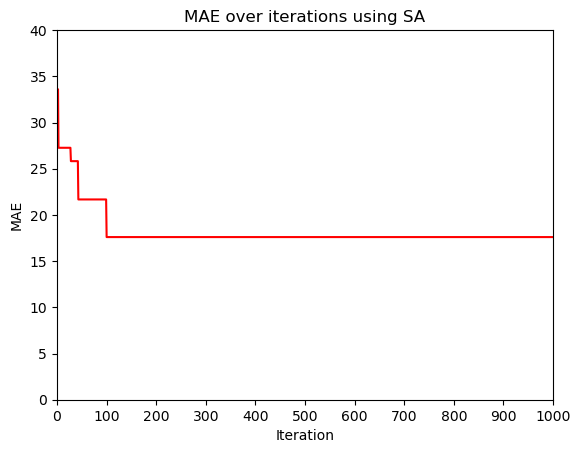

99

In [3]:
import matplotlib.pyplot as plt
import numpy as np
minGEHset = np.loadtxt('SA_DB_best_values.txt', delimiter=',')
# minGEHset = best_values_over_time
plt.plot(range(1,len(minGEHset)+1), minGEHset, '-', color='red') #, markersize=5
plt.xlabel('Iteration')
plt.ylabel('MAE')
plt.title('MAE over iterations using SA')
# plt.legend()
# plt.xticks(ticks=range(0,21))  
plt.xticks(range(0,1001,100))
plt.ylim(0, 40)
plt.xlim(0, 1000)
plt.show()
np.argmin(minGEHset)